# RQ 1. How much time do children spend alone?

In [1]:
import sqlite3
conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/quantex_inference/inference_shorts.db')

# remove everything from AudioClassifications table
conn.execute("DELETE FROM AudioClassifications")
conn.commit()

In [4]:
import pandas as pd
import numpy as np

def time_to_seconds(time_str: str) -> float:
    """Converts a time string (MM:SS or HH:MM:SS) to total seconds, handling empty/NaN inputs."""
    
    # Check for empty or non-string inputs (which often become NaN/empty string from CSV)
    if not isinstance(time_str, str) or not time_str.strip():
        return np.nan # Return NaN for invalid data points
        
    try:
        parts = list(map(int, time_str.split(':')))
        
        if len(parts) == 3: # HH:MM:SS format
            hours, minutes, seconds = parts
            return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2: # MM:SS format
            minutes, seconds = parts
            return minutes * 60 + seconds
    except ValueError:
        return np.nan # Return NaN if time parts cannot be converted to int
    
    return np.nan # Default return for unexpected formats

# 1. Load data, explicitly handling the semicolon delimiter and selecting only required columns
# NOTE: Using the file path provided in your query for live data loading.
df = pd.read_csv(
    "/home/nele_pauline_suffo/outputs/quantex_inference/01_interaction_segments_gt.csv", 
    sep=';', 
    usecols=['video_name', 'interaction_type', 'start_time_min', 'end_time_min']
)

# 2. Convert time columns to total seconds
df['start_sec'] = df['start_time_min'].apply(time_to_seconds)
df['end_sec'] = df['end_time_min'].apply(time_to_seconds)

# Remove any rows where time conversion failed (i.e., returned NaN)
df.dropna(subset=['start_sec', 'end_sec'], inplace=True)

# 3. Calculate duration in seconds
df['duration_sec'] = df['end_sec'] - df['start_sec']

# 4. Find the shortest duration PER INTERACTION TYPE
# Calculate the minimum duration for each interaction type
shortest_durations_per_type = df.groupby('interaction_type')['duration_sec'].min().reset_index()
shortest_durations_per_type = shortest_durations_per_type.rename(columns={'duration_sec': 'shortest_duration_sec'})

# Join back to find the full segment details for each shortest duration
# We use a merge here, but for simplicity and robustness against ties, we calculate the index of the minimum.
# Find the index of the minimum duration for each group
idx_min = df.groupby('interaction_type')['duration_sec'].idxmin()
shortest_segments_per_type = df.loc[idx_min]


print("\n--- Shortest Segment Duration PER INTERACTION TYPE ---")
print(shortest_durations_per_type)
print("\n--- Details of Shortest Segment PER INTERACTION TYPE ---")
print(shortest_segments_per_type[['interaction_type', 'video_name', 'start_time_min', 'end_time_min', 'duration_sec']])



--- Shortest Segment Duration PER INTERACTION TYPE ---
  interaction_type  shortest_duration_sec
0            Alone                    4.0
1        Available                    3.0
2      Interacting                    1.0

--- Details of Shortest Segment PER INTERACTION TYPE ---
   interaction_type                              video_name start_time_min  \
95            Alone  quantex_at_home_id255695_2022_02_12_01          01:14   
38        Available  quantex_at_home_id254922_2022_05_21_01          16:52   
93      Interacting  quantex_at_home_id255695_2022_02_12_01          00:59   

   end_time_min  duration_sec  
95        01:18           4.0  
38        16:55           3.0  
93        01:00           1.0  


In [1]:
import pandas as pd
# Read data
df = pd.read_csv(
    "/home/nele_pauline_suffo/outputs/quantex_inference/01_interaction_segments_gt.csv", 
    sep=';', 
    usecols=['video_name', 'interaction_type', 'start_time_min', 'end_time_min']
)
# Convert MM:SS → timedelta
df['start_time'] = pd.to_timedelta(df['start_time_min'].apply(lambda x: f"00:{x}"))
df['end_time'] = pd.to_timedelta(df['end_time_min'].apply(lambda x: f"00:{x}"))

# Compute duration (in seconds)
df['duration_s'] = (df['end_time'] - df['start_time']).dt.total_seconds()

# Find "Alone" segments that are between two "Interacting" segments
alone_between = []
for i in range(1, len(df) - 1):
    if (
        df.loc[i, 'interaction_type'] == 'Alone'
        and df.loc[i - 1, 'interaction_type'] == 'Interacting'
        and df.loc[i + 1, 'interaction_type'] == 'Interacting'
    ):
        alone_between.append(df.loc[i])

# Convert list to DataFrame
alone_between_df = pd.DataFrame(alone_between)

# Get the one with shortest duration
if not alone_between_df.empty:
    shortest_alone_between = alone_between_df.loc[alone_between_df['duration_s'].idxmin()]
    print(shortest_alone_between)
else:
    print("No 'Alone' segment between two 'Interacting' segments found.")

ValueError: expecting hh:mm:ss format, received: 00::03:13

### Calculate shortest "Alone" segment between two "Interacting" segments

In [4]:
import pandas as pd
import numpy as np

def time_to_seconds(time_str: str) -> float:
    """Converts a time string in MM:SS format to total seconds."""
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan


def calculate_shortest_alone_duration(segment_data: pd.DataFrame) -> dict:
    """
    Finds the shortest 'Alone' segment that is between two 'Interacting' segments.
    Returns the video name, time range, and duration in seconds.
    """
    df = segment_data.copy()
    df.columns = df.columns.str.lower().str.strip()
    df = df.rename(columns={'start_time_min': 'start', 'end_time_min': 'end'})
    df['interaction_type'] = df['interaction_type'].astype(str).str.strip()

    # Convert MM:SS → total seconds
    df['start_sec'] = df['start'].apply(time_to_seconds)
    df['end_sec'] = df['end'].apply(time_to_seconds)
    df['duration'] = df['end_sec'] - df['start_sec']

    # Group by video_name so it works across multiple videos
    results = []

    for video_name, group in df.groupby('video_name'):
        group = group.reset_index(drop=True)

        shortest_segment = None
        shortest_duration = float('inf')

        for i in range(1, len(group) - 1):
            current = group.iloc[i]
            prev = group.iloc[i - 1]
            next_ = group.iloc[i + 1]

            if (
                current['interaction_type'].lower() == 'alone' and
                prev['interaction_type'].lower() == 'interacting' and
                next_['interaction_type'].lower() == 'interacting'
            ):
                duration = current['duration']
                if duration < shortest_duration:
                    shortest_duration = duration
                    shortest_segment = {
                        'video_name': video_name,
                        'start_time': current['start'],
                        'end_time': current['end'],
                        'duration_seconds': duration
                    }

        if shortest_segment:
            results.append(shortest_segment)

    if results:
        # Get global shortest segment across all videos
        shortest_overall = min(results, key=lambda x: x['duration_seconds'])
        shortest_overall['duration_formatted'] = f"{int(shortest_overall['duration_seconds'])} seconds"
        return shortest_overall
    else:
        return {"result": "No 'Alone' segment found between two 'Interacting' segments."}
    
def calculate_shortest_interacting_duration(segment_data: pd.DataFrame) -> dict:
    """
    Finds the shortest 'Interacting' segment that is between two 'Interacting' segments.
    Returns the video name, time range, and duration in seconds.
    """
    df = segment_data.copy()
    df.columns = df.columns.str.lower().str.strip()
    df = df.rename(columns={'start_time_min': 'start', 'end_time_min': 'end'})
    df['interaction_type'] = df['interaction_type'].astype(str).str.strip()

    # Convert MM:SS → total seconds
    df['start_sec'] = df['start'].apply(time_to_seconds)
    df['end_sec'] = df['end'].apply(time_to_seconds)
    df['duration'] = df['end_sec'] - df['start_sec']

    # Group by video_name so it works across multiple videos
    results = []

    for video_name, group in df.groupby('video_name'):
        group = group.reset_index(drop=True)

        shortest_segment = None
        shortest_duration = float('inf')

        for i in range(1, len(group) - 1):
            current = group.iloc[i]
            prev = group.iloc[i - 1]
            next_ = group.iloc[i + 1]

            if (
                current['interaction_type'].lower() == 'interacting' and
                prev['interaction_type'].lower() == 'alone' and
                next_['interaction_type'].lower() == 'alone'
            ):
                duration = current['duration']
                if duration < shortest_duration:
                    shortest_duration = duration
                    shortest_segment = {
                        'video_name': video_name,
                        'start_time': current['start'],
                        'end_time': current['end'],
                        'duration_seconds': duration
                    }

        if shortest_segment:
            results.append(shortest_segment)

    if results:
        # Get global shortest segment across all videos
        shortest_overall = min(results, key=lambda x: x['duration_seconds'])
        shortest_overall['duration_formatted'] = f"{int(shortest_overall['duration_seconds'])} seconds"
        return shortest_overall
    else:
        return {"result": "No 'Interacting' segment found between two 'Alone' segments."}

### Calculate shortest "Interacting" segment between two "Alone" segments

In [5]:
input_df = pd.read_csv(
    "/home/nele_pauline_suffo/outputs/quantex_inference/01_interaction_segments_gt.csv", 
    sep=';', 
    usecols=['video_name', 'interaction_type', 'start_time_min', 'end_time_min']
)
alone_duration = calculate_shortest_alone_duration(input_df)
interacting_duration = calculate_shortest_interacting_duration(input_df)
print("Shortest 'Alone' segment between two 'Interacting' segments:")
print(alone_duration)
print("\nShortest 'Interacting' segment between two 'Alone' segments:")
print(interacting_duration)

Shortest 'Alone' segment between two 'Interacting' segments:
{'video_name': 'quantex_at_home_id255944_2022_03_25_01', 'start_time': '08:47', 'end_time': '08:51', 'duration_seconds': 4.0, 'duration_formatted': '4 seconds'}

Shortest 'Interacting' segment between two 'Alone' segments:
{'video_name': 'quantex_at_home_id254922_2022_05_21_01', 'start_time': '07:21', 'end_time': '07:25', 'duration_seconds': 4.0, 'duration_formatted': '4 seconds'}


### Analyise Missclassifications

In [2]:
import pandas as pd

frame_df = pd.read_csv("/home/nele_pauline_suffo/outputs/quantex_inference/interaction_analysis_20251104_225851/01_frame_level_social_interactions_1_2_3_4_5.csv")
missclassifications_df = pd.read_csv("/home/nele_pauline_suffo/outputs/quantex_inference/interaction_analysis_20251104_225851/misclassified_segments.csv")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.max_rows', None)
missclassifications_df[missclassifications_df['gt_label'] == "alone"]
# sort by duration
missclassifications_available = missclassifications_df[missclassifications_df['gt_label'] == "available"].sort_values(by='duration_sec', ascending=False)
missclassifications_available = missclassifications_available.reset_index(drop=True)

missclassifications_alone = missclassifications_df[missclassifications_df['gt_label'] == "alone"].sort_values(by='duration_sec', ascending=False)
missclassifications_alone = missclassifications_alone.reset_index(drop=True)

missclassifications_interacting = missclassifications_df[missclassifications_df['gt_label'] == "interacting"].sort_values(by='duration_sec', ascending=False)
missclassifications_interacting = missclassifications_interacting.reset_index(drop=True)


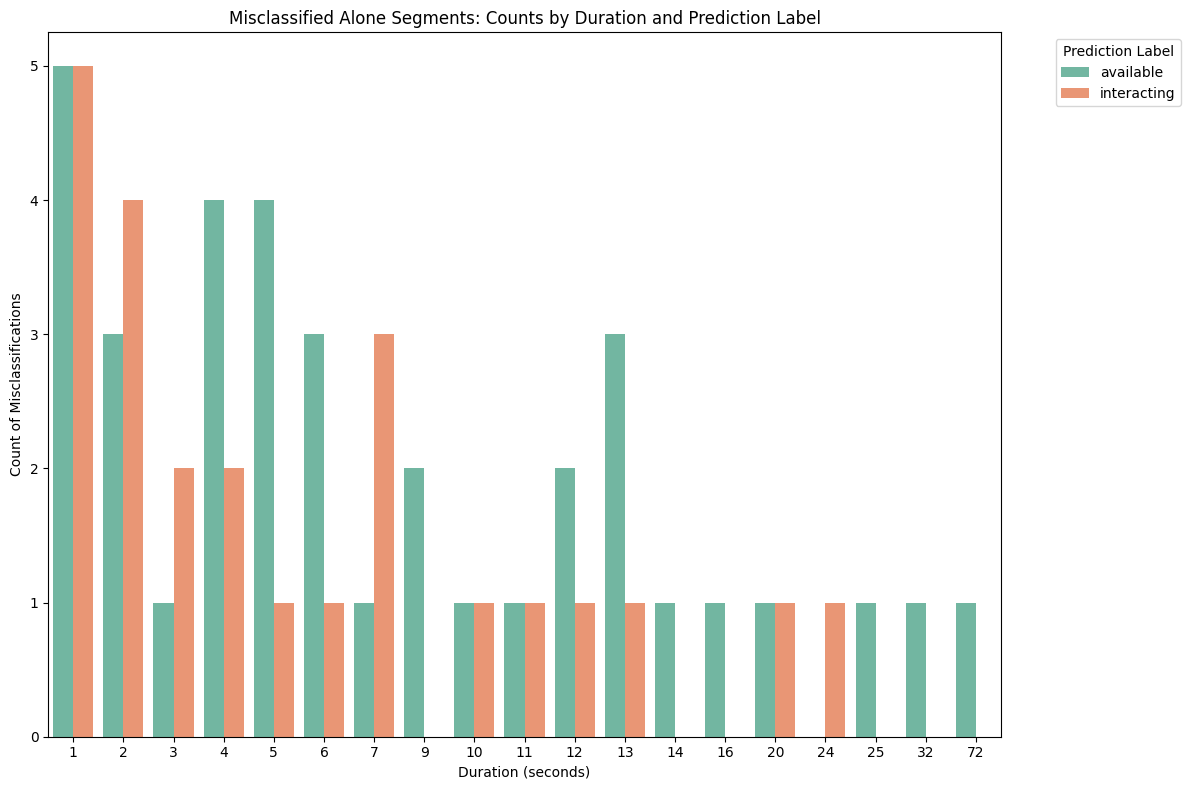

In [3]:
# Group by duration and predicted label
counts = (
    missclassifications_alone
    .groupby(["duration_sec", "pred_label"])
    .size()
    .reset_index(name="count")
)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=counts,
    x="duration_sec",
    y="count",
    hue="pred_label",
    palette="Set2"
)

plt.title("Misclassified Alone Segments: Counts by Duration and Prediction Label")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Misclassifications")
plt.legend(title="Prediction Label", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### Available Missclassifications 

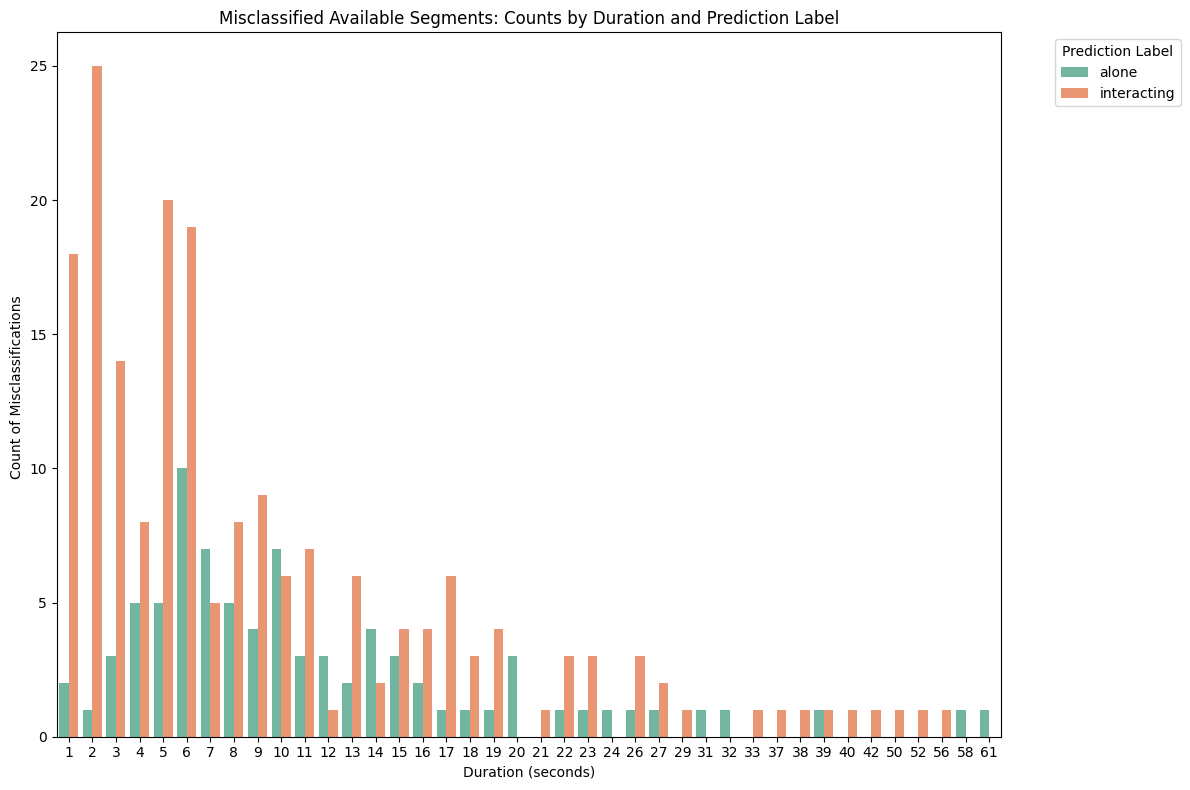

In [4]:

# Group by duration and predicted label
counts = (
    missclassifications_available
    .groupby(["duration_sec", "pred_label"])
    .size()
    .reset_index(name="count")
)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=counts,
    x="duration_sec",
    y="count",
    hue="pred_label",
    palette="Set2"
)

plt.title("Misclassified Available Segments: Counts by Duration and Prediction Label")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Misclassifications ")
plt.legend(title="Prediction Label", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [7]:
missclassifications_available.head(10)

video_name  start_sec  end_sec   gt_label  \
0  quantex_at_home_id255944_2022_03_25_01        362      422  available   
1  quantex_at_home_id254922_2022_05_21_01       1035     1092  available   
2  quantex_at_home_id255237_2022_05_08_03       1570     1625  available   
3  quantex_at_home_id255706_2022_04_16_01        280      331  available   
4  quantex_at_home_id255695_2022_02_21_01        684      733  available   
5  quantex_at_home_id255944_2022_03_25_02       1015     1056  available   
6  quantex_at_home_id255944_2022_03_25_02        240      279  available   
7  quantex_at_home_id255695_2022_02_21_01        954      992  available   
8  quantex_at_home_id255237_2022_05_26_01        994     1032  available   
9  quantex_at_home_id255237_2022_05_26_01       1481     1518  available   

    pred_label  duration_sec  
0        alone            61  
1        alone            58  
2  interacting            56  
3  interacting            52  
4  interacting            50  
5  interacting            42  
6  interacting            40  
7        alone            39  
8  interacting            39  
9  interacting            38

#### Interacting Missclassifications 

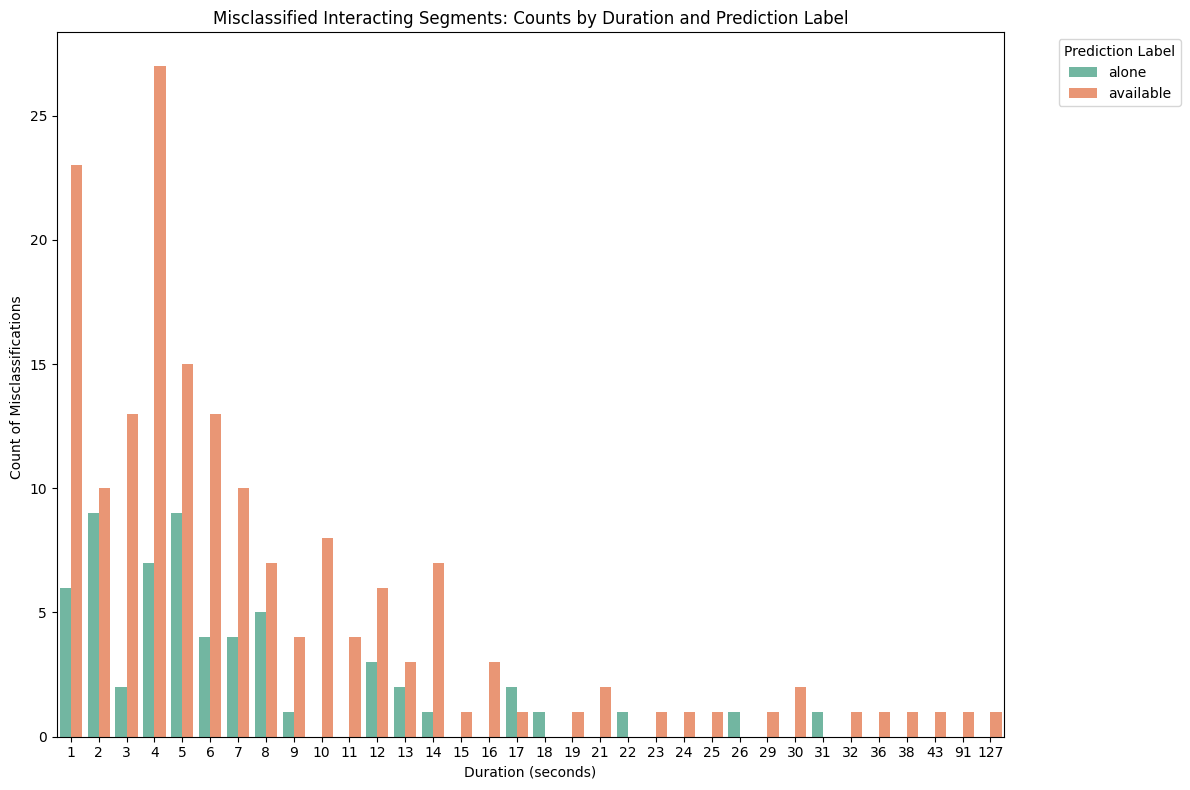

In [5]:
# Group by duration and predicted label
counts = (
    missclassifications_interacting
    .groupby(["duration_sec", "pred_label"])
    .size()
    .reset_index(name="count")
)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=counts,
    x="duration_sec",
    y="count",
    hue="pred_label",
    palette="Set2"
)

plt.title("Misclassified Interacting Segments: Counts by Duration and Prediction Label")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Misclassifications ")
plt.legend(title="Prediction Label", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
missclassifications_interacting.head(10)

video_name  start_sec  end_sec     gt_label  \
0  quantex_at_home_id255237_2022_05_26_01        415      541  interacting   
1  quantex_at_home_id255237_2022_05_26_01        763      853  interacting   
2  quantex_at_home_id255237_2022_05_26_01        873      915  interacting   
3  quantex_at_home_id255237_2022_05_26_01        250      287  interacting   
4  quantex_at_home_id255237_2022_05_08_03        170      205  interacting   
5  quantex_at_home_id255237_2022_05_26_01        371      402  interacting   
6  quantex_at_home_id255695_2022_02_21_01       1293     1323  interacting   
7  quantex_at_home_id254922_2022_04_12_01        938      967  interacting   
8  quantex_at_home_id255237_2022_05_08_03       1329     1358  interacting   
9  quantex_at_home_id255944_2022_03_25_02        920      948  interacting   

  pred_label  duration_sec  
0  available           127  
1  available            91  
2  available            43  
3  available            38  
4  available            36  
5  available            32  
6      alone            31  
7  available            30  
8  available            30  
9  available            29

In [9]:
frame_df[frame_df['video_name'] == "quantex_at_home_id255237_2022_05_26_01"]

frame_number  video_id                              video_name  \
16057             0        13  quantex_at_home_id255237_2022_05_26_01   
16058            10        13  quantex_at_home_id255237_2022_05_26_01   
16059            20        13  quantex_at_home_id255237_2022_05_26_01   
16060            30        13  quantex_at_home_id255237_2022_05_26_01   
16061            40        13  quantex_at_home_id255237_2022_05_26_01   
16062            50        13  quantex_at_home_id255237_2022_05_26_01   
16063            60        13  quantex_at_home_id255237_2022_05_26_01   
16064            70        13  quantex_at_home_id255237_2022_05_26_01   
16065            80        13  quantex_at_home_id255237_2022_05_26_01   
16066            90        13  quantex_at_home_id255237_2022_05_26_01   
16067           100        13  quantex_at_home_id255237_2022_05_26_01   
16068           110        13  quantex_at_home_id255237_2022_05_26_01   
16069           120        13  quantex_at_home_id255237_2022_05_26_01   
16070           130        13  quantex_at_home_id255237_2022_05_26_01   
16071           140        13  quantex_at_home_id255237_2022_05_26_01   
16072           150        13  quantex_at_home_id255237_2022_05_26_01   
16073           160        13  quantex_at_home_id255237_2022_05_26_01   
16074           170        13  quantex_at_home_id255237_2022_05_26_01   
16075           180        13  quantex_at_home_id255237_2022_05_26_01   
16076           190        13  quantex_at_home_id255237_2022_05_26_01   
16077           200        13  quantex_at_home_id255237_2022_05_26_01   
16078           210        13  quantex_at_home_id255237_2022_05_26_01   
16079           220        13  quantex_at_home_id255237_2022_05_26_01   
16080           230        13  quantex_at_home_id255237_2022_05_26_01   
16081           240        13  quantex_at_home_id255237_2022_05_26_01   
16082           250        13  quantex_at_home_id255237_2022_05_26_01   
16083           260        13  quantex_at_home_id255237_2022_05_26_01   
16084           270        13  quantex_at_home_id255237_2022_05_26_01   
16085           280        13  quantex_at_home_id255237_2022_05_26_01   
16086           290        13  quantex_at_home_id255237_2022_05_26_01   
16087           300        13  quantex_at_home_id255237_2022_05_26_01   
16088           310        13  quantex_at_home_id255237_2022_05_26_01   
16089           320        13  quantex_at_home_id255237_2022_05_26_01   
16090           330        13  quantex_at_home_id255237_2022_05_26_01   
16091           340        13  quantex_at_home_id255237_2022_05_26_01   
16092           350        13  quantex_at_home_id255237_2022_05_26_01   
16093           360        13  quantex_at_home_id255237_2022_05_26_01   
16094           370        13  quantex_at_home_id255237_2022_05_26_01   
16095           380        13  quantex_at_home_id255237_2022_05_26_01   
16096           390        13  quantex_at_home_id255237_2022_05_26_01   
16097           400        13  quantex_at_home_id255237_2022_05_26_01   
16098           410        13  quantex_at_home_id255237_2022_05_26_01   
16099           420        13  quantex_at_home_id255237_2022_05_26_01   
16100           430        13  quantex_at_home_id255237_2022_05_26_01   
16101           440        13  quantex_at_home_id255237_2022_05_26_01   
16102           450        13  quantex_at_home_id255237_2022_05_26_01   
16103           460        13  quantex_at_home_id255237_2022_05_26_01   
16104           470        13  quantex_at_home_id255237_2022_05_26_01   
16105           480        13  quantex_at_home_id255237_2022_05_26_01   
16106           490        13  quantex_at_home_id255237_2022_05_26_01   
16107           500        13  quantex_at_home_id255237_2022_05_26_01   
16108           510        13  quantex_at_home_id255237_2022_05_26_01   
16109           520        13  quantex_at_home_id255237_2022_05_26_01   
16110           530        13  quantex_at_home_id255237_2022_05_2